In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import glob
import scipy.ndimage as sim


import utils

Fig1

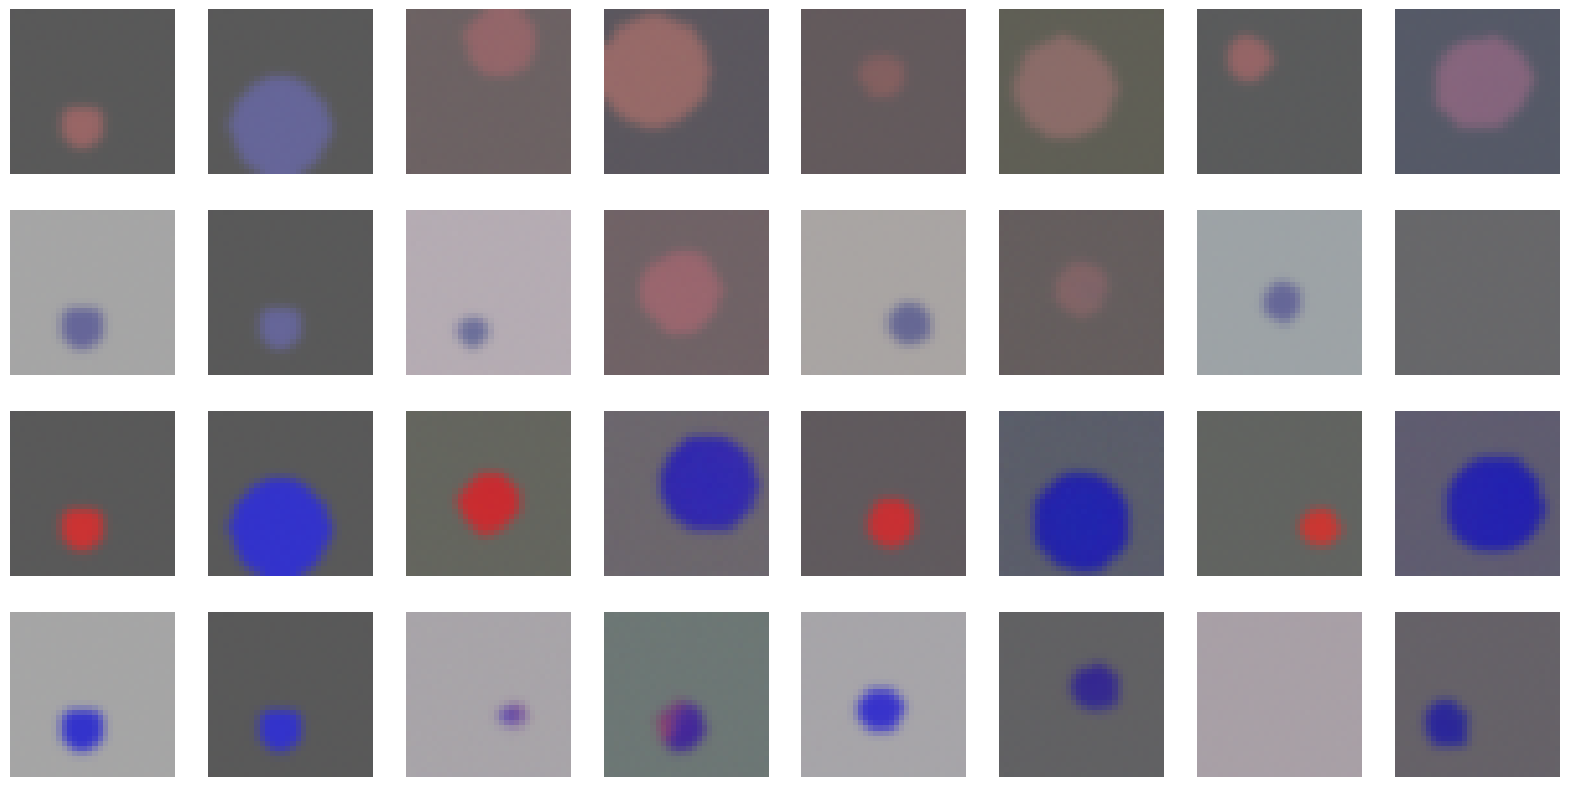

In [42]:
fols=["./data/images_1/2x2x2_final/sc3ss1sb3/sep_col=0.2_sep_size=0.35_sep_bg_col=0.3/seed=0/",
      #"./data/images_1/2x2x2_final/sc3ss1sb3/sep_col=0.6_sep_size=0.35_sep_bg_col=0.2/seed=0/",
    #"./data/images_1/2x2x2_final/sc3ss1sb3/sep_col=0.4_sep_size=0.35_sep_bg_col=0.3/seed=0/",
    "./data/images_1/2x2x2_final/sc3ss1sb3/sep_col=0.6_sep_size=0.35_sep_bg_col=0.3/seed=100/"
      ]
im_steps=[9896,19603,40_000]
plt.figure(figsize=(20,10))
n_rows=2*len(fols)
n_cols=2*(len(im_steps)+1)
for i_fol,fol in enumerate(fols):
    config=utils.load_config(glob.glob(os.path.join(fol,"*.yaml"))[0])
    config["n_samples_train"]=[0]*8
    config["n_samples_test"]=[0]*8
    config["n_samples_train_gen"]=[0]*8
    config["n_samples_test_gen"]=[32]*8
    _,_,_,x_te,y_te,l_te=utils.generate_data(config,seed=42,forgen=True)
    generation_fol=os.path.join(fol,"generations")
    generation_paths=glob.glob(os.path.join(generation_fol,"*.pth"))
    #
    def get_step(path):
        return int(os.path.basename(path).split("_")[-1].split(".")[0])
    generation_paths=dict([(get_step(path),path) for path in generation_paths])
    for i in range(4):
        l=[3,5,6,7][i]
        subcol=i%2
        col=0+subcol
        subrow=i//2
        row=2*i_fol+subrow
        plt.subplot(n_rows,n_cols,row*n_cols+col+1)
        ims=np.clip(x_te[l==l_te][0].transpose(1,2,0),0,1)
        plt.imshow(ims.transpose(1,0,2),origin="lower")
        plt.axis("off")
    for i_step,im_step in enumerate(im_steps):
        generation=torch.load(generation_paths[im_step])
        gen_te=generation["gen_te"]
        l_te_gen=generation["l_te_gen"]
        for i in range(4):
            l=[3,5,6,7][i]
            subcol=i%2
            col=(i_step+1)*2+subcol
            subrow=i//2
            row=2*i_fol+subrow
            plt.subplot(n_rows,n_cols,row*n_cols+col+1)
            ims=np.clip(gen_te[l==l_te_gen][0].transpose(1,2,0),0,1)
            plt.imshow(ims.transpose(1,0,2),origin="lower")
            plt.axis("off")

In [33]:
generation_paths.keys()

dict_keys([792, 20060, 28627, 11926, 6147, 16974, 886, 38078, 7767, 3669, 19152, 34980, 3103, 40000, 26474, 183, 21461, 9896, 4496, 20522, 23902, 5408, 542, 31436, 35589, 12283, 39354, 13763, 22910, 703, 282, 2585, 8648, 14146, 12645, 50, 4716, 16140, 7484, 2925, 14927, 24406, 29178, 3868, 339, 2114, 5172, 4281, 469, 2422, 8952, 22422, 16554, 17399, 36823, 106, 17829, 620, 20989, 10221, 8055, 1089, 19603, 142, 1690, 24915, 34376, 14534, 5895, 3286, 27005, 29735, 230, 2265, 1826, 2752, 30296, 15326, 38713, 4072, 25430, 13012, 75, 15730, 37448, 32013, 33184, 21939, 1559, 1314, 10888, 36203, 6666, 18265, 1434, 28081, 5649, 9576, 18706, 6404, 11229, 25949, 4942, 1967, 30863, 32596, 401, 1199, 27540, 3475, 6933, 33777, 9262, 11575, 7206, 13385, 23404, 985, 10552, 8349])

Fig2

In [96]:
save_dir="./data/to_maya/fig2"
os.makedirs(save_dir, exist_ok=True)

In [8]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
thres=0.1

In [140]:
fols=glob.glob("./data/images_1/2x2x2_final/sc3ss1sb3/*/*/")
rows=[]
for fol in fols:
    pfolname=os.path.basename(os.path.dirname(fol))
    seed=int(pfolname.split("seed=")[1].split("_")[0])

    ppfolname=os.path.basename(os.path.dirname(os.path.dirname(fol)))
    sep_col=float(ppfolname.split("sep_col=")[1].split("_")[0])
    sep_size=float(ppfolname.split("sep_size=")[1].split("_")[0])
    sep_bgcol=float(ppfolname.split("sep_bg_col=")[1].split("_")[0])
    if sep_bgcol not in [0.1,0.2,0.3]:
        continue

    pix_mse=np.load(os.path.join(fol,"mse_pix.npy"))
    d_000_001=pix_mse[0,1]
    d_000_010=pix_mse[0,2]
    d_001_011=pix_mse[1,3]
    d_010_011=pix_mse[2,3]

    d_000_100=pix_mse[0,4]
    d_001_101=pix_mse[1,5]
    d_010_110=pix_mse[2,6]
    d_011_111=pix_mse[3,7]

    d_100_101=pix_mse[4,5]
    d_100_110=pix_mse[4,6]
    d_101_111=pix_mse[5,7]
    d_110_111=pix_mse[6,7]


    config_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
    config=utils.load_config(config_file)
    save_steps=np.array(config["save_steps"])
    plot_data=torch.load(os.path.join(fol,"plot_data.pth"))

    classprobs_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
    l_tr=np.array(plot_data['l_tr'])
    classprobs_te=np.array(plot_data['classprobs_pred_te'])[...,1]
    l_te=np.array(plot_data['l_te'])
    #print(classprobs_tr.shape,classprobs_te.shape)

    trajs=[]
    for l in range(8):
        if l in [0,1,2,4]:
            trajs.append(classprobs_tr[:,:,l_tr==l].mean(-1))
        else:
            trajs.append(classprobs_te[:,:,l_te==l].mean(-1))
    trajs=np.stack(trajs,axis=0)


    gts=np.array([[0.,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]])
    trajs_smooth=sim.gaussian_filter1d(trajs,1.0,axis=1,truncate=6.0)
    accs=sigmoid(1/(np.abs(gts[:,None,:]-trajs_smooth)/thres+1e-9))

    trajs=trajs.transpose(0,2,1).reshape(-1)
    accs=accs.transpose(0,2,1).reshape(-1)

    rows.append([sep_col,sep_size,sep_bgcol,seed,
                 d_000_001,d_000_010,d_001_011,d_010_011,
                    d_000_100,d_001_101,d_010_110,d_011_111,
                    d_100_101,d_100_110,d_101_111,d_110_111,
                    *trajs,*accs,
                    ])
    #break
classnames=np.array(["000","001","010","011","100","101","110","111"])
dimnames=np.array(["color","size","bgcolor"])
header_traj=np.char.add("traj_",classnames)
header_traj=np.char.add(header_traj,"_")
header_traj=np.char.add(header_traj[:,None],dimnames[None,:]).flatten()
header_traj=np.char.add(header_traj,"_")
header_traj=np.char.add(header_traj[:,None],save_steps[None,:].astype(str)).flatten()
header_acc=np.char.add("acc_",classnames)
header_acc=np.char.add(header_acc,"_")
header_acc=np.char.add(header_acc[:,None],dimnames[None,:]).flatten()
header_acc=np.char.add(header_acc,"_")
header_acc=np.char.add(header_acc[:,None],save_steps[None,:].astype(str)).flatten()
header=["sep_col","sep_size","sep_bgcol","seed",
        "d_000_001","d_000_010","d_001_011","d_010_011",
        "d_000_100","d_001_101","d_010_110","d_011_111",
        "d_100_101","d_100_110","d_101_111","d_110_111",
        *header_traj,*header_acc
        ]
data=np.array(rows)

print(len(rows),len(rows[0]),len(header))

np.savetxt(os.path.join(save_dir,"fig2_data.csv"),data,header=",".join(header),delimiter=",",comments="",fmt='%.4f')

45 5776 5776


Fig3

In [73]:
save_dir="./data/to_maya/fig3"
os.makedirs(save_dir, exist_ok=True)

In [74]:
def get_i_learned(accs,consistent=3):
    assert consistent%2==1
    #find portion of acc where accs is positive for 3 values
    structure=np.ones(consistent)
    goods=sim.binary_erosion(accs,structure=structure)
    inds=np.nonzero(goods)[0]
    if len(inds)>=1:
        return np.min(inds)
    else:
        return None

In [75]:
fols=glob.glob("./data/images_1/2x2_final2/detailed/*/*/")
rows=[]
for fol in fols:
    pfolname=os.path.basename(os.path.dirname(fol))
    seed=int(pfolname.split("seed=")[1].split("_")[0])

    ppfolname=os.path.basename(os.path.dirname(os.path.dirname(fol)))
    sep_col=float(ppfolname.split("sep_col=")[1].split("_")[0])
    sep_size=float(ppfolname.split("sep_size=")[1].split("_")[0])

    pix_mse=np.load(os.path.join(fol,"mse_pix.npy"))
    d_00_01=pix_mse[0,1]
    d_00_10=pix_mse[0,2]
    d_01_11=pix_mse[1,3]
    d_10_11=pix_mse[2,3]

    config_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
    config=utils.load_config(config_file)
    save_steps=np.array(config["save_steps"])
    plot_data=torch.load(os.path.join(fol,"plot_data.pth"))
    acc=plot_data["rights_te"].mean(1)
    coloracc=acc[:,0]
    sizeacc=acc[:,1]

    #calc time
    thres=0.9
    acc_smoothed=sim.gaussian_filter1d(acc,1.5,axis=0)
    i_learned_col=get_i_learned(acc_smoothed[:,0]>thres) 
    i_learned_size=get_i_learned(acc_smoothed[:,1]>thres)
    step_learned_col=-1 if i_learned_col is None else save_steps[i_learned_col]
    step_learned_size=-1 if i_learned_size is None else save_steps[i_learned_size]

    rows.append([sep_col,sep_size,seed,d_00_01,d_00_10,d_01_11,d_10_11,step_learned_col,step_learned_size,*coloracc,*sizeacc])
    #break
header_step_col=[str(s) for s in np.char.add("coloracc_",save_steps.astype(str))]
header_step_size=[str(s) for s in np.char.add("sizeacc_",save_steps.astype(str))]
header=["sep_col","sep_size","seed","d_00_01","d_00_10","d_01_11","d_10_11","step_learned_col","step_learned_size",*header_step_col,*header_step_size]
data=np.array(rows)
np.savetxt(os.path.join(save_dir,"fig3_data.csv"),data,header=",".join(header),delimiter=",",comments="",fmt='%.4f')

fig 4

In [132]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
thres=0.1

In [176]:
fols=glob.glob("./data/images_1/2x2_final2/col_sweep/*/*/")
rows=[]
for fol in fols:
    pfolname=os.path.basename(os.path.dirname(fol))
    seed=int(pfolname.split("seed=")[1].split("_")[0])

    ppfolname=os.path.basename(os.path.dirname(os.path.dirname(fol)))
    sep_col=float(ppfolname.split("sep_col=")[1].split("_")[0])
    sep_size=float(ppfolname.split("sep_size=")[1].split("_")[0])

    #pix_mse=np.load(os.path.join(fol,"mse_pix.npy"))
    d_00_01=0#pix_mse[0,1]
    d_00_10=0#pix_mse[0,2]
    d_01_11=0#pix_mse[1,3]
    d_10_11=0#pix_mse[2,3]

    config_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
    config=utils.load_config(config_file)
    save_steps=np.array(config["save_steps"])
    plot_data=torch.load(os.path.join(fol,f"plot_data.pth"))
    classprobs_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
    l_tr=np.array(plot_data['l_tr'])
    classprobs_te=np.array(plot_data['classprobs_pred_te'])[...,1]
    l_te=np.array(plot_data['l_te'])

    trajs=[]
    for l in range(4):
        if l in [0,1,2]:
            trajs.append(classprobs_tr[:,:,l_tr==l].mean(-1))
        else:
            trajs.append(classprobs_te[:,:,l_te==l].mean(-1))
    trajs=np.stack(trajs,axis=0)

    gts=np.array([[0.,0],[0,1],[1,0],[1,1]])
    trajs_smooth=sim.gaussian_filter1d(trajs,2.0,axis=1,truncate=6.0)
    accs=sigmoid(1/(np.abs(gts[:,None,:]-trajs_smooth)/thres+1e-9))

    trajs_=trajs.transpose(0,2,1).reshape(-1)
    accs_=accs.transpose(0,2,1).reshape(-1)

    rows.append([str(sep_col),sep_size,seed,*trajs_,*accs_])

In [177]:
data=np.array(rows)

In [178]:
sel=(data[:,0]=="0.8") & (data[:,1]=="0.4")
sel.sum()

5

In [179]:
i_datas=np.nonzero(sel)[0]
trajs=[]
for i_data in i_datas:
    trajs_=data[i_data][3:3+480]
    trajs_=trajs_.reshape(4,2,60).astype(float)
    trajs.append(trajs_)
trajs=np.stack(trajs,axis=0)
trajs_smooth=sim.gaussian_filter1d(trajs,sigma=2.0,axis=-1,truncate=6.0)

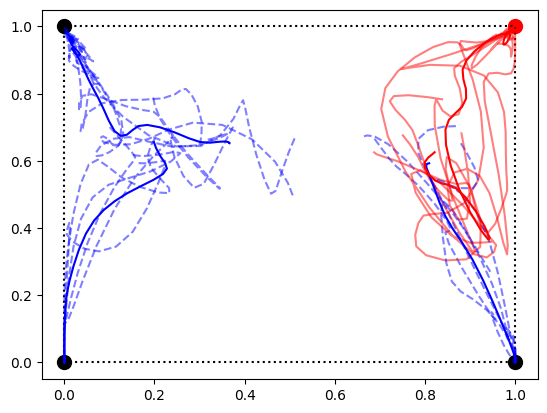

In [180]:
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)

cs=["b","b","b","r"]
for b in range(5):
    for i in range(4):
        ls="-" if i==3 else "--"
        plt.plot(trajs_smooth[b,i,0,:],trajs_smooth[b,i,1,:],ls=ls,c=cs[i],alpha=0.5)
meantraj=trajs_smooth.mean(0)
for i in range(4):
    plt.plot(meantraj[i,0,:],meantraj[i,1,:],c=cs[i])


Fig prediction

In [9]:
import torch
import matplotlib.pyplot as plt
data=torch.load("./figures/final/dist_to_time.pth")
torch.save(data, "./data/to_maya/fig_geopred/data.pth")

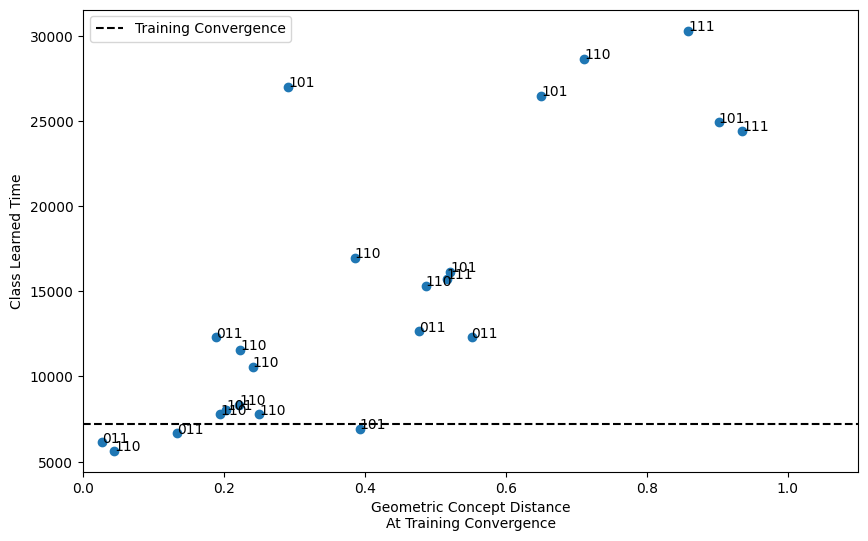

In [10]:
import torch
import matplotlib.pyplot as plt
data=torch.load("./figures/final/dist_to_time.pth")

distances=data["distances"]
learned_steps=data["learned_steps"]
labels=data["labels"]
tr_learned_step=data["tr_learned_step"]

plt.figure(figsize=(10,6))
_=plt.scatter(distances,learned_steps)
for label,d,lt in zip(labels,distances,learned_steps):
    plt.text(d,lt,label)
plt.axhline(tr_learned_step,c="k",ls="--",label="Training Convergence")
plt.xlim(0,1.1)
plt.xlabel("Geometric Concept Distance\nAt Training Convergence")
plt.ylabel("Class Learned Time")
plt.legend()
#plt.savefig("./figures/final/dist_to_time.png")

fig cfg

In [167]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
thres=0.1

In [168]:
fols=glob.glob("./data/images_1/2x2_final2/col_sweep_cfg/*/*/")
rows=[]
for fol in fols:
    for cfg,suffix in zip([1.0,2.0,3.0,7.5],["_w_cfg_1.0","_w_cfg_2.0","_w_cfg_3.0","_w_cfg_7.5"]):
        pfolname=os.path.basename(os.path.dirname(fol))
        seed=int(pfolname.split("seed=")[1].split("_")[0])

        ppfolname=os.path.basename(os.path.dirname(os.path.dirname(fol)))
        sep_col=float(ppfolname.split("sep_col=")[1].split("_")[0])
        sep_size=float(ppfolname.split("sep_size=")[1].split("_")[0])

        #pix_mse=np.load(os.path.join(fol,"mse_pix.npy"))
        d_00_01=0#pix_mse[0,1]
        d_00_10=0#pix_mse[0,2]
        d_01_11=0#pix_mse[1,3]
        d_10_11=0#pix_mse[2,3]

        config_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
        config=utils.load_config(config_file)
        save_steps=np.array(config["save_steps"])
        plot_data=torch.load(os.path.join(fol,f"plot_data{suffix}.pth"))
        classprobs_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        l_te=np.array(plot_data['l_te'])

        trajs=[]
        for l in range(4):
            if l in [0,1,2]:
                trajs.append(classprobs_tr[:,:,l_tr==l].mean(-1))
            else:
                trajs.append(classprobs_te[:,:,l_te==l].mean(-1))
        trajs=np.stack(trajs,axis=0)

        gts=np.array([[0.,0],[0,1],[1,0],[1,1]])
        trajs_smooth=sim.gaussian_filter1d(trajs,2.0,axis=1,truncate=6.0)
        accs=sigmoid(1/(np.abs(gts[:,None,:]-trajs_smooth)/thres+1e-9))

        trajs_=trajs.transpose(0,2,1).reshape(-1)
        accs_=accs.transpose(0,2,1).reshape(-1)

        rows.append([sep_col,sep_size,str(cfg),seed,*trajs_,*accs_])
        #rows.append([sep_col,sep_size,seed,d_00_01,d_00_10,d_01_11,d_10_11,step_learned_col,step_learned_size,*coloracc,*sizeacc])
#header_step_col=[str(s) for s in np.char.add("coloracc_",save_steps.astype(str))]
#header_step_size=[str(s) for s in np.char.add("sizeacc_",save_steps.astype(str))]
#header=["sep_col","sep_size","seed","d_00_01","d_00_10","d_01_11","d_10_11","step_learned_col","step_learned_size",*header_step_col,*header_step_size]
#data=np.array(rows)

In [169]:
data=np.array(rows)

In [170]:
trajs.shape

(4, 60, 2)

In [171]:
tts=[]
for cfg in [1.0,2.0,3.0,7.5]:
    sel=(data[:,0]=="0.763") & (data[:,1]=="0.4") & (data[:,2]==str(cfg))
    i_datas=np.nonzero(sel)[0]
    trajs=[]
    for i_data in i_datas:
        trajs_=data[i_data][4:4+480]
        trajs_=trajs_.reshape(4,2,60).astype(float)
        trajs.append(trajs_)
    trajs=np.stack(trajs,axis=0)
    tts.append(sim.gaussian_filter1d(trajs,sigma=2.0,axis=-1,truncate=6.0))
tts=np.stack(tts,axis=0)
tts.shape

(4, 5, 4, 2, 60)

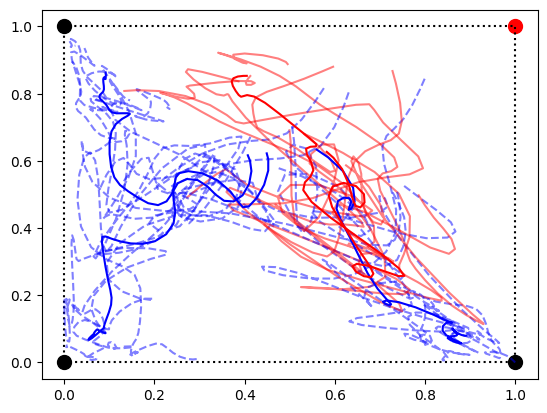

In [172]:
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)

cs=["b","b","b","r"]
for i_cfg in [0]:
    for b in range(5):
        for i in range(4):
            ls="-" if i==3 else "--"
            plt.plot(tts[i_cfg,b,i,0,:],tts[i_cfg,b,i,1,:],ls=ls,c=cs[i],alpha=0.5)
    meantraj=tts[i_cfg].mean(0)
    for i in range(4):
        plt.plot(meantraj[i,0,:],meantraj[i,1,:],c=cs[i])


In [34]:
acc.shape

(50, 2)

In [20]:
len(fols)

245